In [59]:
import numpy as np
import matplotlib.pyplot as plt
import yaml

In [60]:
""" Parameters """
max_dist = 15
fov_deg = 150
fov_rad = fov_deg * np.pi / 180

""" Load track """
track = yaml.load(open('trackdrive.yaml', 'r'), Loader=yaml.FullLoader)
cones = track['cones']
blue = cones['blue']
yellow = cones['yellow']
all_cones = np.concatenate((blue, yellow), axis=0)
initial_pose = np.array([
    track['initial_pose']['x'],
    track['initial_pose']['y'],
    track['initial_pose']['yaw'],
])

# Homogenous coordinates for colorless cones
cones = np.zeros((len(all_cones), 3))
cones[:, :2] = all_cones
cones[:, 2] = 1

In [61]:
""" Helpers """
_n = 1
def to_m_frame(cones: np.ndarray((_n,3)), pose: np.ndarray((3,))) -> np.ndarray((_n,2)):
    """ Convert cones to car frame """
    x, y, yaw = pose
    return np.vstack((
        np.linalg.norm(cones[:, :2] - pose[:2], axis=1),
        np.arctan2(cones[:, 1] - y, cones[:, 0] - x) - yaw,
        cones[:, 2]
    )).T

def to_g_frame(cones: np.ndarray((_n,3)), pose: np.ndarray((3,))) -> np.ndarray((_n,2)):
    """ Convert cones to global frame """
    x, y, yaw = pose
    return np.vstack((
        cones[:, 0] * np.cos(cones[:, 1] + yaw) + x,
        cones[:, 0] * np.sin(cones[:, 1] + yaw) + y,
        cones[:, 2]                          
    )).T

assert np.allclose(to_g_frame(to_m_frame(cones, initial_pose), initial_pose), cones)

(-21.22803, 23.509629999999998, -19.287299369716802, 27.621086764052826)

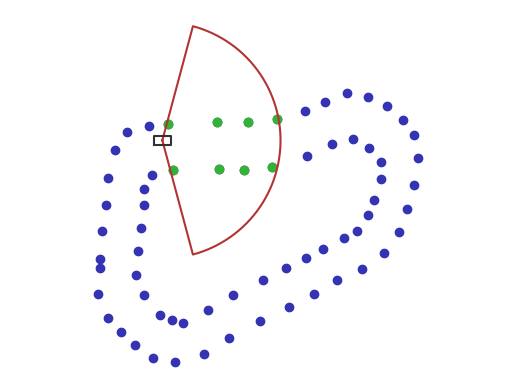

In [64]:
""" Create visulization """
_n = 1
def plot_cones(cones: np.ndarray((_n,2)), color: np.ndarray((3)) = (0.2,0.2,0.7)):
    """ Plot cones """
    plt.scatter(cones[:, 0], cones[:, 1], color=color)

def plot_fov(pose: np.ndarray((3,))):
    """ Plot field of view """
    x = pose[0]
    y = pose[1]
    yaw = pose[2]

    fov = np.array([
        [ x, y ],
        *[ [x + max_dist * np.cos(yaw + phi), y + max_dist * np.sin(yaw + phi)] for phi in np.linspace(-fov_rad/2, fov_rad/2, 60) ],
        [ x, y ]
    ])
    plt.plot(fov[:, 0], fov[:, 1], color=(0.7,0.2,0.2))

def plot_car(pose: np.ndarray((3,))):
    """ Plot a car """
    x, y, yaw = pose
    car = np.array([
        [ -1.1, -0.6],
        [ 1.1, -0.6],
        [ 1.1, 0.6],
        [ -1.1, 0.6],
        [ -1.1, -0.6],
    ])
    R = np.array([
        [ np.cos(yaw), -np.sin(yaw) ],
        [ np.sin(yaw), np.cos(yaw) ],
    ])
    car = car @ R + np.array([x, y])

    plt.plot(car[:, 0], car[:, 1], color=(0.2,0.2,0.2))

def get_visible_cones(cones: np.ndarray((_n,3)), pose: np.ndarray((3,))) -> np.ndarray((_n,2)):
    """ Get visible cones in car frame """
    cones = to_m_frame(cones, pose)
    cones = cones[(0 < cones[:, 0])*(cones[:, 0] < max_dist)*(abs(cones[:, 1]) < fov_rad/2)]
    cones = to_g_frame(cones, pose)
    return cones

plot_cones(all_cones)
plot_cones(get_visible_cones(cones, initial_pose), color=(0.2,0.7,0.2))
plot_fov(initial_pose)
plot_car(initial_pose)
plt.axis('equal')
plt.axis('off')